In [43]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from timeit import default_timer
import seaborn as sns

In [44]:
def step_function(r, x_t, f_x, g,  d_t, x0, L): #Algorithm 3
    if type(x0) == int:
        x0 = x_t 
        #print("x0:", x0)
    epsilon = 10e-3
    k1 = 0.9
    k2 = 2
    nL = k1 * L
    den=d_t.T @ d_t # ||d||^2
    if den==0: # since it goes to the denominator I check that it is not 0
      den=0.0000001 #think about substituting this with a stop of the algorithm
    clip = g ** 2 / ((2 * (objective(x0, r) - f_x) * den)+0.0000001) # this value ha to be comprised between nL and L
    
    M = np.clip(clip ,nL, L) ## the value clip is bounded by upper bound nL and lower bound L 
    
        
        
    
    bound = g / (M * den) 
    gamma = min(bound, 1)
    #whiel the function is bigger than quadratic approximation do:
    while objective(x_t + (gamma * d_t), r) > (f_x - (gamma * g) + ( (gamma ** 2) * M) * (den)) : 
        M = k2 * M
        bound = g / ((M * den)+0.0000001) 
        
        gamma = min(bound, 1)
    return gamma,  M

The computation of the cost function can be seen as matrix multiplication between:

*    $R$ with size $(m, n)$, where $m$ is the number of periods and $n$ is the number of assets, so that the row $i$ represents the value of the return of each assets in the period $i$
*   $x$ that is the column vector with shape $(n, 1)$ that gives us the percentage to invest for each asset.

In this way the matrix multiplication between each row of $R$ and $x$ will correspond to exponential of the each element of the summatory $\sum_{i=1}^{T} ln(r_{i}x)$, where $T$ is the number of period. So what is left is to apply the logaritmic function to every of those terms.



In [45]:
def objective(x, r):
  x=x.reshape(-1,1) #reshape the vector to perform the next operation
  a=np.dot(r, x ) #dot product
  a=np.where(a!=0, a, a+0.00000001) #eleminating eventual zero elements
  #a will be a vector of m elements, one for each period
  return np.sum(-np.log(a))

The computation of the gradient follows the same logic as before, we will get a colum vector of 250 elements, and then we will perform an element wise multiplication between this vector and the matrix $R$. After this we will sum with respect to the colum in order to get the gradient for each element of $x$.

In [46]:
def gradient(x, r):
    x=x.reshape(-1,1)
    a=np.dot(r, x )
    a=np.where(a!=0, a, a+0.00000001) #up to here same as befor
    return np.sum(-(1/a)*r, axis=0) # multiplying for R and summing with respect to the column

In [47]:
def arimjo_ls(xt, fx, gamma_max, gt, dt, r):
    gamma = gamma_max
    p = 0.1*(-gt) # quantity that goes in the armijo line search
    f= objective(xt + gamma * dt, r)
    while (f > (fx + gamma * p)): # while the function is biggr than the linear approximation
      gamma=0.7*gamma #reduce the step size
      f = objective(xt + gamma * dt, r) 
    return gamma
    

In [48]:
def LMO(gradient_xt): 
    sti = np.argmin(gradient_xt) 
    st = np.zeros(gradient_xt.shape[0])
    st[sti]=1 # simplex[sti] only thing left to be defined is simplex
    return st, sti

In [49]:
def frank_wolfe(objective, gradient, return_matrix, max_iter):
    # n_periods = return_matrix.shape[0]
    n_assets = return_matrix.shape[1]
    
    eps = 1e-6
    # Our solution is a vector x, |x| = n_assets - 
    # investment distribution
    # We pick initial approximation for x - any
    # simplex vertex
    vertex_to_start = 1
    assert vertex_to_start < n_assets, print('Pick another initial approximation')
    x = np.zeros(n_assets)
    x[vertex_to_start] = 1  # initial approximation - all money to one asset

    objective_values = [objective(x, return_matrix)]  # objective function
    gap_list=[]

    algo_start = default_timer()
    iterations_counter = 0
    for k in range(1, max_iter + 1):
        iterations_counter += 1
        # Compute gradient of objective function
        grad_vector = gradient(x, return_matrix)
        #assert(grad_vector.shape[0] == len(x))

        # FW for simplex problem --> minimum of linear
        # function will be reached on the vertex of the simplex
        # Here we search for index with minimum gradient
        # component
        min_index = np.argmin(grad_vector)
        #assert grad_vector[min_index] <= 0, print(f'Minimum of gradient vector is positive')
        
        # x_k^ = e_ik from lectures - direction where to go
        xk_hat = np.zeros(n_assets)
        assert(len(xk_hat) == len(grad_vector))
        xk_hat[min_index] = 1
        d = (xk_hat - x)
        gap=-grad_vector @ d
        gap_list.append(gap)
        if gap <= eps:
            print(f'Satisfied exiting condition')
            break
        else:
            learning_rate = 2 / (k + 1)
            x = x + learning_rate * d
            obj = objective(x, return_matrix)
            
            objective_values.append(obj)  # objective function
    # that sum of distribution is 100%
    algo_end = default_timer()
    delta_t = algo_end - algo_start
    return x, objective_values, gap_list, iterations_counter

In [50]:
def variant2(objective,  gradient, r,  max_iter = 1000):
  eps = 1e-6
  
      
  xt  = np.zeros(r.shape[1])
  xt[0]=1
  x0=0 #initialize this variable to keep track of the previus value of x w.r.t. to the curret iteration
  #it is needed in the step_function
  gap_list=[]
  
  o=[] #store the objective function values during the iteration
  algo_start = default_timer()
  for i in range(max_iter):
    if i==0:
        
        L=1 #initialize the L costant, to be sostituted with the right euristic
    
    g  = gradient(xt, r)
    fxt  = objective(xt,r )
    o.append(fxt)
    st, sti = LMO(g)#linear minimizer oracle
    d =  st - xt 
    gap=- g @ d #computing the gap
    gap_list.append(gap)
    if gap<= eps: #checking the stopping condition
      print('early exit')
      algo_end = default_timer()
      delta_t = algo_end - algo_start
      return [xt, o, gap_list, i]
    gamma, L = step_function(r, xt, fxt, gap,  d, x0, L)
    x0=xt #keeping track of the past value of x for the next iteration
    xt += gamma*d #updating x
  algo_end = default_timer()
  delta_t = algo_end - algo_start
  return [xt,  o, gap_list, max_iter]

In [51]:
def FW_PW_correct(objective,  gradient, r,  max_iter = 1000):
    eps = 1e-6
    active_set=np.eye(r.shape[1]) # the active set has as vertexes the characteristic vectors
    gap_list=[]
    
    
    xt  = active_set[0, :] #itiliaze x with the fisrt vertex
    #for the part of the code concerning the weights see the paper for a more detailed explenations
    ind=[0] #list of indexes correspondig to the vertexes that are into set1 (see below)
    weights = np.zeros(r.shape[1]) #we have a weight for each vertex of the active set
    #we also have another set (set1 corresponding to S in the paper) where there 
    #are all the vertexes that can be chosen to compute the away direction
     
    weights[ind] = 1 #we set the weights corresponding to the vertexes that are in set1 equal to one, the rest is equal to zero
    
    o=[] 
    algo_start = default_timer()
    for i in range(max_iter):
        
        set1=active_set[ind,:] #create the set1 where there are all the vertexes with the corresponding weights different from 0
        g  = gradient(xt, r)
        fxt  = objective(xt,r )
        o.append(fxt)
        st, sti = LMO( g) #linear minimizer oracle
        vti = np.argmax(g[ind]) #away vertex
        vt = set1[vti]

        vti=ind[vti] #trick, since vti will correspond to the index in set1, that is smaller than active set 
        #I retrive the corresponding index in the active set
        
        dt = st - vt #pairwise direction
        gfw =  - g @ dt #gap
        gap_list.append(gfw)
        if gfw <= eps: #stopping condition
          print('early exit')
          algo_end = default_timer()
          delta_t = algo_end - algo_start
          return [xt, o, gap_list, i]
         
        gamma_max = weights[vti] #gamma max equal to the weight corresponding to the away vertex
        
        gamma = arimjo_ls(xt, fxt, gamma_max, gfw, dt, r)
        weights[vti] -= gamma #updating the weights according to the paper
        weights[sti] += gamma
         #updating the list of indexes correspondig to the non zero weights
        if (abs(xt[vti]) <= 0.0001): #removing weights that are too little
            #active_set = np.delete(active_set, vti, 0)
            weights[vti]=0
        ind=(np.array(list(range(weights.shape[0])))[(weights>0)]).tolist()
        
        
        
        xt += gamma*dt
    algo_end = default_timer()
    delta_t = algo_end - algo_start
    return [xt,  o, gap_list, max_iter]

In [52]:
def plot_objective_function(values):
    fig, ax = plt.subplots()
    fontsize = 20
    labelsize = 16
    legendsize = 15

    for a, s in values.items():
        ax.plot(s, marker = 'o', markerfacecolor = 'white', label=a)
        leg = ax.legend(prop = {'size': legendsize})

    ax.tick_params(labelsize = labelsize)
    plt.xlabel('Number of iteration', fontsize = fontsize)
    plt.ylabel('Objective function', fontsize = fontsize)
    plt.title('Objective function', fontsize = fontsize)
    plt.grid()

In [53]:
def plot_gap(values):

    fontsize = 20
    labelsize = 16
    legendsize = 15

    fig, ax = plt.subplots()
    for a, s in values.items():
        ax.plot(s, marker = 'o', markerfacecolor = 'white', label=a)
        leg = ax.legend(prop = {'size': legendsize})
    ax.tick_params(labelsize = labelsize)
    plt.xlabel('Number of iteration', fontsize = fontsize)
    plt.ylabel('Relative Error', fontsize = fontsize)
    plt.title('Relative Error', fontsize = fontsize)
    plt.grid()

In [54]:
def plot_return_matrix(return_matrix, x_lim, assets):
    fig, ax = plt.subplots()

    for asset in assets:
        ax.plot(return_matrix[:x_lim, asset], marker = 'o', markerfacecolor = 'white')

    fontsize = 20
    labelsize = 15
    legend_size = 15

    plt.ylim([0, 1.5])
    plt.xlabel('Period 1 .. T', fontsize = fontsize)
    plt.tick_params(labelsize = labelsize)

    plt.title(f'First {x_lim} samples for {len(assets)} assets', fontsize = fontsize)
    plt.ylabel('Return', fontsize = fontsize)
    plt.legend([f'Asset {n + 1}' for n in assets], prop = {'size': legend_size})
    plt.grid()

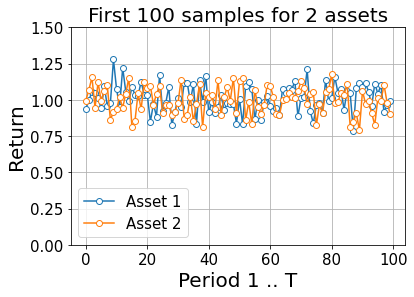

In [55]:
return_matrix = np.ones((100, 4)) + np.random.normal(loc = 0, scale = 0.1, size = (100, 4))
plot_return_matrix(return_matrix, x_lim = 100, assets = [0, 1])

In [56]:
def plot_bar_scores(scores_dict, y_label, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y_label, fontsize = 18)
    ax.set_title(title, fontsize = 18)

    x_vals = scores_dict.keys()
    y_vals = scores_dict.values()
    
    ax.bar(x_vals, y_vals, width = 0.4)
    ax.tick_params(labelsize = 16)
    plt.grid()
    plt.show()

def run_experiment(n_assets, n_periods, max_iterations, fun):
    mean = 0  # like in paper
    var = 0.1  # like in paper
    np.random.seed(43)
    i={}
    o={}
    g={}
    t={}
    n_iterations = {}
    # Create return matrix as in the paper
    # (N periods) x (N assets) matrix
    return_matrix = np.ones((n_periods, n_assets)) + np.random.normal(loc = mean, scale = var, size = (n_periods, n_assets))
    assert(return_matrix.shape == (n_periods, n_assets))
    assert(len(return_matrix[:, 0]) == n_periods)
    assert(len(return_matrix[0, :]) == n_assets)

    plot_return_matrix(return_matrix, x_lim = 100, assets = [0, 1, 2])

    for f in fun:
      start=time.time()
      investment_distribution, objective_func, gap, n_iters = f(objective,  gradient, return_matrix,  max_iter = max_iterations)
      stop=time.time()
      
      i[f'{f.__name__}']=investment_distribution
      o[f'{f.__name__}']=objective_func
      g[f'{f.__name__}']=gap
      t[f'{f.__name__}']=[stop-start]
      n_iterations[f'{f.__name__}'] = n_iters

      if investment_distribution.sum()>=0.999:
        print(f'{f.__name__}', ' has done a correct execution')

    plot_objective_function(o)
    plot_gap(g)
    
    plot_bar_scores(
        n_iterations, 
        'Number of iterations', 
        'Iterations of algorithms'
    )

    plot_bar_scores(
        {k: v[0] for k, v in t.items()}, 
        'CPU time, sec', 
        'Computational time of algorithms'
    )

    invest_distributions = np.array([v for v in i.values()])
    sns.heatmap(invest_distributions)

    display('Time to execution', pd.DataFrame(t))
    return i, o, g, t, n_iterations

frank_wolfe  has done a correct execution
variant2  has done a correct execution
FW_PW_correct  has done a correct execution


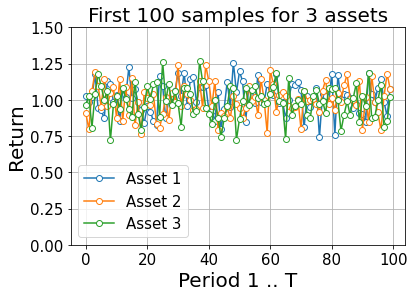

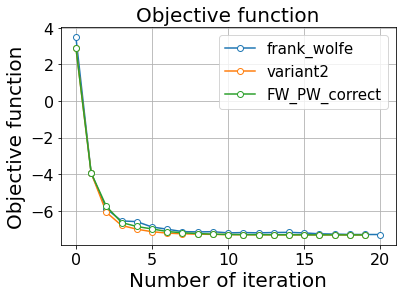

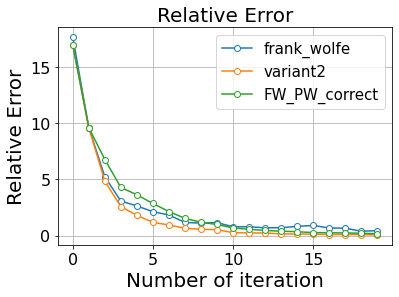

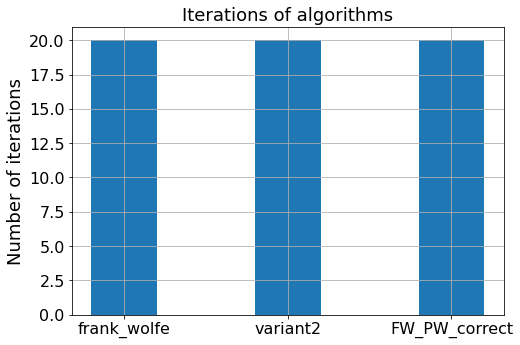

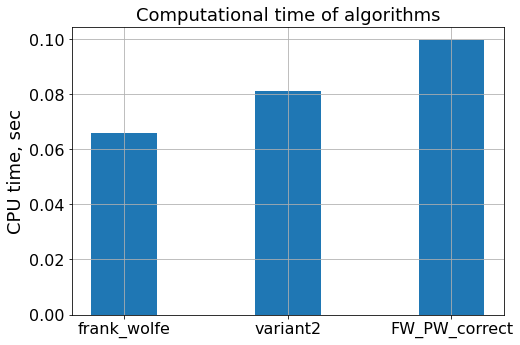

'Time to execution'

,frank_wolfe,variant2,FW_PW_correct
0,0.065755,0.081097,0.09953


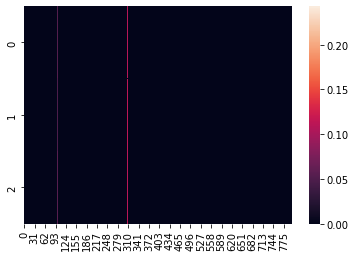

In [60]:
investments_800, objective_func_800, gaps_800, dts_800, n_iterations_800 = run_experiment(
    n_assets = 800, 
    n_periods = 1000, 
    max_iterations = 20, 
    fun = [frank_wolfe, variant2, FW_PW_correct]
)

frank_wolfe  has done a correct execution
variant2  has done a correct execution
FW_PW_correct  has done a correct execution


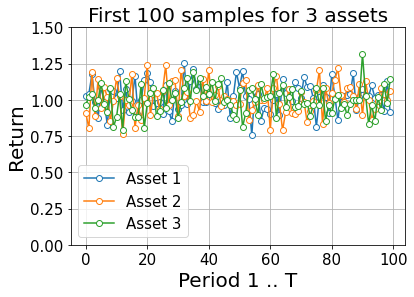

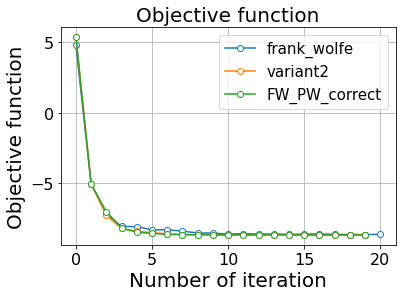

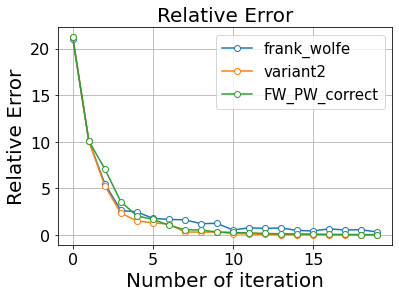

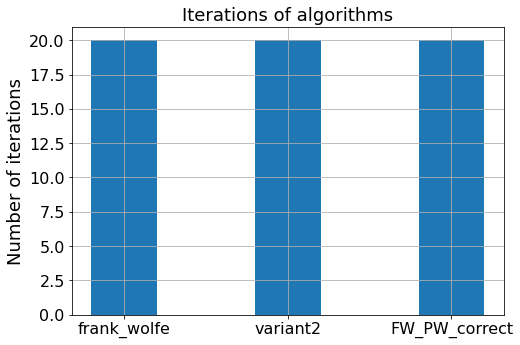

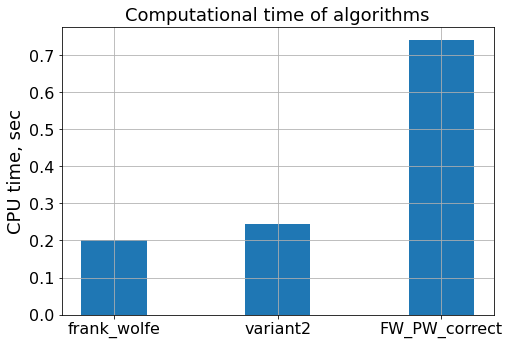

'Time to execution'

,frank_wolfe,variant2,FW_PW_correct
0,0.201571,0.243871,0.739744


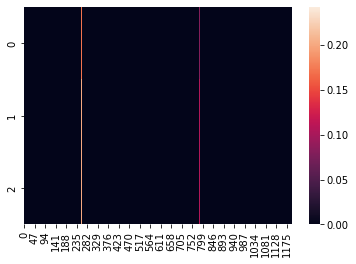

In [61]:
investments_1200, objective_func_1200, gaps_1200, dts_1200, n_iterations_1200 = run_experiment(
    n_assets = 1200, 
    n_periods = 1000, 
    max_iterations = 20, 
    fun = [frank_wolfe, variant2, FW_PW_correct]
)

frank_wolfe  has done a correct execution
variant2  has done a correct execution
FW_PW_correct  has done a correct execution


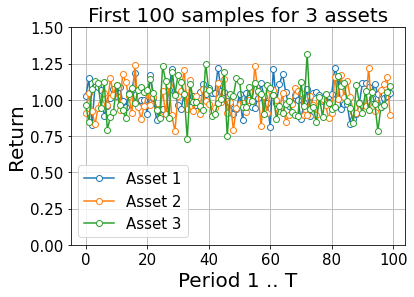

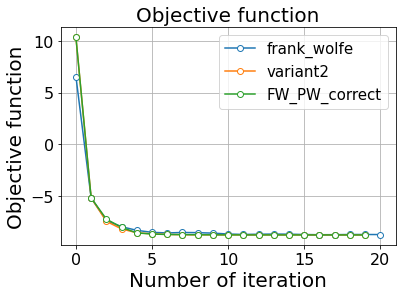

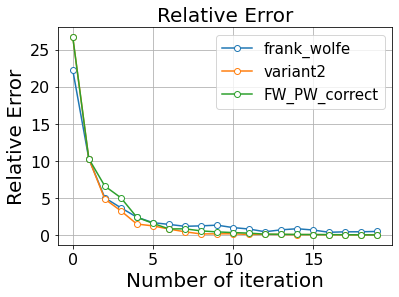

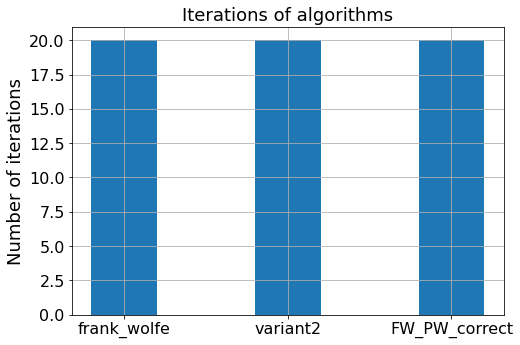

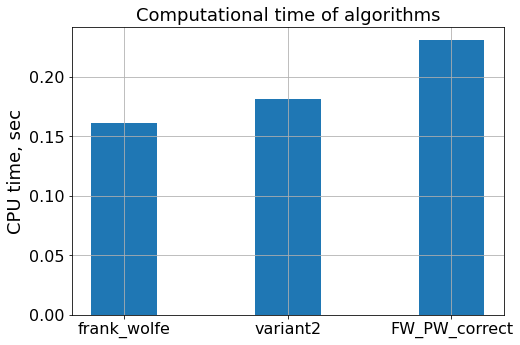

'Time to execution'

,frank_wolfe,variant2,FW_PW_correct
0,0.160968,0.181344,0.230767


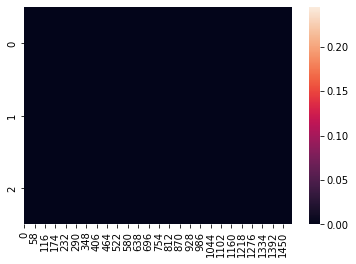

In [62]:
investments_1500, objective_func_1500, gaps_1500, dts_1500, n_iterations_1500 = run_experiment(
    n_assets = 1500, 
    n_periods = 1000, 
    max_iterations = 20, 
    fun = [frank_wolfe, variant2, FW_PW_correct]
)

## Compare results of experiments

## Compare number of iterations

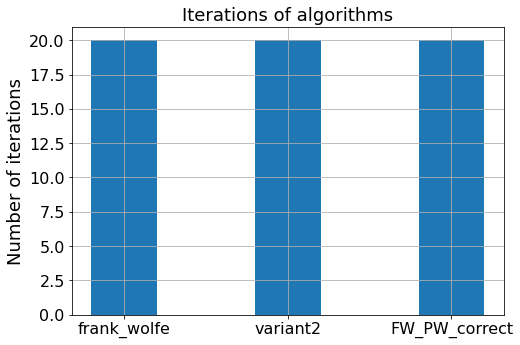

In [63]:
plot_bar_scores(
    n_iterations_800, 
    'Number of iterations', 
    'Iterations of algorithms'
)

## Compare computational time

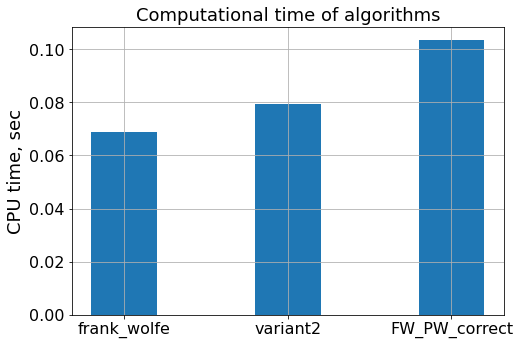

In [ ]:
plot_bar_scores(
    {k: v[0] for k, v in dts.items()}, 
    'CPU time, sec', 
    'Computational time of algorithms'
)

## Compare objective functions and relative errors

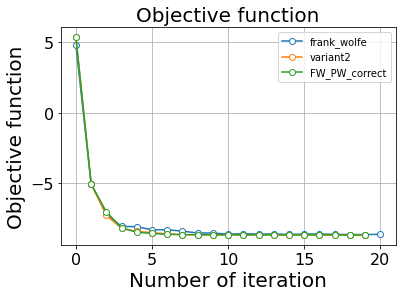

In [ ]:
plot_objective_function(objective_func)

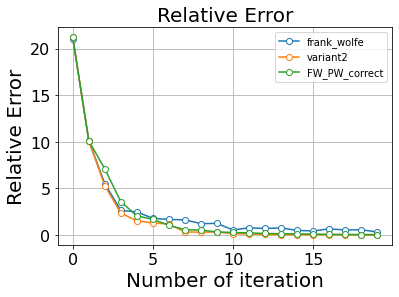

In [ ]:
plot_gap(gaps)

## Compare finance distribution

Here, we visualize with heatmap, where the algorithms recommend to invest money (which one of the offered assets). As it is seen in the visualisation, all algorithms converge to similar recommendations

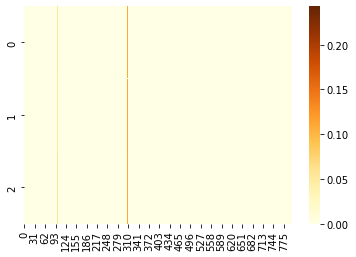

In [70]:
invest_distributions = np.array([v for v in investments_800.values()])
sns.heatmap(invest_distributions, cmap = sns.color_palette("YlOrBr", as_cmap=True))